<a href="https://colab.research.google.com/github/IMOKURI/atmacup11/blob/main/atmacup11_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook ...

- Competition site: [atma cup #11](https://www.guruguru.science/competitions/17/)
- [WandB training logs](https://wandb.ai/imokuri/atma11)







## Prepare for Colab

In [1]:
!nvidia-smi

Wed Jul 14 13:59:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/gdrive')

        !cp /gdrive/MyDrive/Datasets/dataset_atmaCup11.zip .

        !unzip dataset_atmaCup11.zip
        !mkdir -p photos
        !unzip photos.zip -d photos
        !mv 'atmaCup#11_sample_submission.csv' atmaCup11_sample_submission.csv

    # for StratifiedGroupKFold
    !pip uninstall -y scikit-learn
    !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

    !pip install -q wandb
    !pip install -Uq timm
    !pip install -Uq albumentations

    !touch init.txt

Already initialized.


## Library

In [3]:
import glob
import json
import math
import os
import random
import time
import warnings
from contextlib import contextmanager

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from albumentations.pytorch import ToTensorV2
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [4]:
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!wandb login 99be4cf161ada45b19189d933d9bae42e9928398

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
wandb_job_type = ""
wandb_notes = ""
wandb_tags = []

## Load Data

In [8]:
DATA_DIR = "../input/atmacup11/"
BASE_DIR = "../input/atmacup11/photos/"
OUTPUT_DIR = "./"

if 'google.colab' in sys.modules:
    DATA_DIR = "./"
    BASE_DIR = "./photos/"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [9]:
paths = [path for path in glob.glob(BASE_DIR + "*.jpg")]
print(len(paths))

9856


In [10]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "atmaCup11_sample_submission.csv")
material = pd.read_csv(DATA_DIR + "materials.csv")
technique = pd.read_csv(DATA_DIR + "techniques.csv")

In [11]:
# https://www.guruguru.science/competitions/17/discussions/000d76a9-fc4b-443e-95f2-5c066c0f3108/
train["sorting_date_target"] = train["sorting_date"] / 100.0 - 15.51

In [12]:
for ds in [train, test, sub]:
    print(f"=" * 80)
    ds.info()
    display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   object_id            3937 non-null   object 
 1   sorting_date         3937 non-null   int64  
 2   art_series_id        3937 non-null   object 
 3   target               3937 non-null   int64  
 4   sorting_date_target  3937 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 153.9+ KB


,object_id,sorting_date,art_series_id,target,sorting_date_target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1,0.80
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3,3.49
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3,2.83
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2,1.92
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3,3.34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5919 entries, 0 to 5918
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   object_id  5919 non-null   object
dtypes: object(1)
memory usage: 46.4+ KB


,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5919 entries, 0 to 5918
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  5919 non-null   int64
dtypes: int64(1)
memory usage: 46.4 KB


,target
0,3
1,1
2,3
3,3
4,0


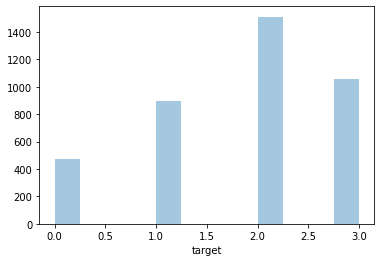

In [13]:
sns.distplot(train["target"], kde=False)

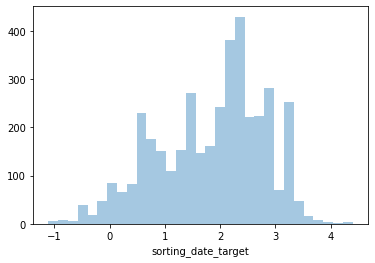

In [14]:
sns.distplot(train["sorting_date_target"], kde=False)

In [15]:
train["art_series_id"].value_counts()

607c22f5e66e8d50a298    9
6fb734ceff36fe2184b5    7
78db88c5ca6d7f6f4ac6    6
9f6b6e88a57613d73742    4
f8b88aff7f66a106ba3f    4
                       ..
a28bd50ffff5affad742    1
4b58505af4cf8f632bcd    1
3586b7c8e6567fd62ef4    1
51912d9677ec24826a3a    1
2488b8f822b16c952b4c    1
Name: art_series_id, Length: 3784, dtype: int64

## Config

In [16]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "atma11"
    print_freq = 50

    train = False
    validate = True
    inference = True

    debug = False
    multi_gpu = False
    apex = False


In [17]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

In [18]:
if Config.apex:
    from apex import amp

In [19]:
seed = random.randrange(10000)
# seed = 440

In [20]:
config_defaults = {
    "seed": seed,
    "size": 256,
    "n_class": 1,
    "n_fold": 5,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "num_workers": 4,
    "batch_size": 16,
    "epochs": 20,
    "scheduler": "CosineAnnealingWarmRestarts",
    "criterion": "RMSELoss",
    "lr": 1e-3,
    "min_lr": 1e-4,
    "weight_decay": 1e-6,
    "model_name": "seresnext26d_32x4d",
    "inference_runs": [
        "3r29llv1", # 36
        "2r8nooek", # 33
        "1t1k9jk5", # 34
        "viccx8lc", # 35
    ],
    "no_aug": True,
}


In [21]:
if config_defaults["scheduler"] == "CosineAnnealingWarmRestarts":
    config_defaults["T_0"] = config_defaults["epochs"]

elif config_defaults["scheduler"] == "CosineAnnealingLR":
    config_defaults["T_max"] = config_defaults["epochs"]

elif config_defaults["scheduler"] == "ReduceLROnPlateau":
    config_defaults["factor"] = 0.2
    config_defaults["patience"] = 4
    config_defaults["eps"] = 1e-6


In [22]:
if Config.debug:
    config_defaults["epochs"] = 1

In [23]:
if Config.debug:
    wandb.init(project=Config.wandb_project, config=config_defaults, mode="disabled")
else:
    wandb.init(project=Config.wandb_project, config=config_defaults, notes=wandb_notes, tags=wandb_tags, job_type=wandb_job_type, save_code=True)

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [24]:
config = wandb.config

## Load Models

In [25]:
if Config.validate or Config.inference:
    api = wandb.Api()
    inference_models = []

    for n, run_id in enumerate(config.inference_runs):
        if not os.path.exists(run_id):
            os.makedirs(run_id)

        run_path = f"{Config.wandb_entity}/{Config.wandb_project}/{run_id}"
        run = api.run(run_path)

        try:
            for file in run.files():
                file.download(run_id)
        except wandb.CommError:
            # Already downloaded.
            pass

        inference_model = {}
        inference_model["run_id"] = run_id
        inference_model["model_name"] = run.config["model_name"]
        
        for fold in range(config.n_fold):
            model_preds = torch.load(f"{run_id}/{inference_model['model_name']}_fold{fold}_best.pth")
            inference_model[f"state_fold{fold}"] = model_preds["model"]
            inference_model[f"preds_fold{fold}"] = model_preds["preds"]

        oof = pd.read_csv(f"{run_id}/oof_df.csv")[["object_id", "preds"]]
        oof.columns = ["object_id", f"preds{n}"]
        train = pd.merge(train, oof, on="object_id", )

        inference_models.append(inference_model)
    
    print(train.columns)
    print({m['run_id']: m['model_name'] for m in inference_models})

Index(['object_id', 'sorting_date', 'art_series_id', 'target',
       'sorting_date_target', 'preds0', 'preds1', 'preds2', 'preds3'],
      dtype='object')
{'3r29llv1': 'resnet34d', '2r8nooek': 'resnet18d', '1t1k9jk5': 'tf_efficientnetv2_b0', 'viccx8lc': 'efficientnet_b0'}


In [26]:
if Config.debug:
    train = train.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    test = test.sample(n=1000, random_state=config.seed).reset_index(drop=True)
    sub = sub.sample(n=1000, random_state=config.seed).reset_index(drop=True)

## Utils

In [27]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)


## CV Split

In [28]:
folds = train.copy()
Fold = StratifiedGroupKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["target"], folds["art_series_id"])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(np.uint8)
print(folds.groupby(["fold", "target"]).size())


fold  target
0     0         106
      1         179
      2         284
      3         213
1     0          96
      1         159
      2         323
      3         206
2     0          88
      1         163
      2         316
      3         224
3     0          85
      1         209
      2         292
      3         201
4     0         100
      1         186
      2         296
      3         211
dtype: int64


## Dataset

In [29]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["object_id"].values
        self.labels = df["sorting_date_target"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{BASE_DIR}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).float()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["object_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{BASE_DIR}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image


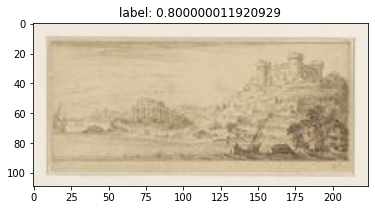

In [30]:
# Test

train_ds = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_ds[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()


## Transform

In [31]:
def get_transforms(*, data):

    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size, scale=(0.5, 1.0)),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                A.CoarseDropout(p=0.5),
                A.Cutout(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "weak_train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size, scale=(0.5, 1.0)),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                # A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                # A.CoarseDropout(p=0.5),
                # A.Cutout(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                # A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )


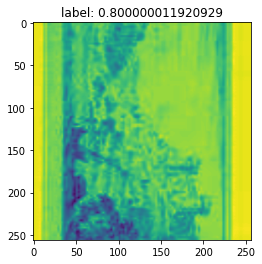

In [32]:
# Test

train_ds = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_ds[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()


## Model

In [33]:
class Atma11Net(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "res" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("vit_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)
            
        elif "nfnet" in model_name:
            n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(n_features, config.n_class)

    def forward(self, x):
        x = self.model(x).view(x.size(0))
        return x


In [34]:
# Test

model = Atma11Net(model_name=config.model_name, pretrained=False)
print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break


Atma11Net(
  (model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Loss

In [35]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss


## Scoring

In [36]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [37]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["target"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    # wandb.log({"fold": fold, "CV": score})
    if fold == config.n_fold:
        wandb.run.summary[f"CV"] = score
    else:
        wandb.run.summary[f"CV_fold{fold}"] = score


## Helper functions

In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [39]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        y_preds = model(images.float())

        loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps
        if Config.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.val:.4f}({losses.avg:.4f}) "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_last_lr()[0]:.6f}  "
            )

    return losses.avg

In [40]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # compute loss
        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # record accuracy
        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())
        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.val:.4f}({losses.avg:.4f}) "
            )
    predictions = np.clip(np.concatenate(preds), 0, 3)
    return losses.avg, predictions

In [41]:
def inference(test_loader):
    predictions = []
    for model_item in inference_models:
        for fold in range(config.n_fold):
            LOGGER.info(f"========== ID: {model_item['run_id']} model: {model_item['model_name']} fold: {fold} inference ==========")
            model = Atma11Net(model_item["model_name"])
            model.to(device)
            model.load_state_dict(model_item[f"state_fold{fold}"])
            model.eval()
            preds = []
            for i, (images) in enumerate(test_loader):
                images = images.to(device)
                with torch.no_grad():
                    y_preds = model(images)
                # avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
                preds.append(y_preds.to("cpu").numpy())
            preds = np.concatenate(preds)
            predictions.append(preds)
    predictions = np.clip(np.mean(predictions, axis=0), 0, 3)
    return predictions


## Train loop

In [42]:
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_weak_aug = TrainDataset(train_folds, transform=get_transforms(data="weak_train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_weak_aug = DataLoader(
        train_dataset_weak_aug,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if config.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=config.factor, patience=config.patience, verbose=True, eps=config.eps
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=config.T_max, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        return scheduler

    # ====================================================
    # Model & Optimizer
    # ====================================================
    model = Atma11Net(config.model_name)
    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not Config.apex and Config.multi_gpu:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # Apex
    # ====================================================
    if Config.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "RMSELoss":
            criterion = RMSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = np.inf
    best_loss = np.inf

    # if not Config.multi_gpu:
    #     wandb.watch(model, log_freq=Config.print_freq)

    for epoch in range(config.epochs):

        start_time = time.time()

        # train
        if config.no_aug or epoch <= 1 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device)
        elif epoch >= config.epochs - 5:
            avg_loss = train_fn(train_loader_weak_aug, model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["target"].values

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/val_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        if score < best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth"
            )
            wandb.save(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

        # if epoch == config.epochs - 1:
        #     LOGGER.info(f"Epoch {epoch+1} - Save final model")
        #     torch.save(
        #         {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{config.model_name}_fold{fold}_final.pth"
        #     )

    check_point = torch.load(OUTPUT_DIR + f"{config.model_name}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"]  # .argmax(1)

    return valid_folds

## Main


In [43]:
def main():
    if Config.train:
        oof_df = pd.DataFrame()
        for fold in range(config.n_fold):
            _oof_df = train_loop(folds, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")
        
    if Config.validate:
        probs = []

        for n, model_item in enumerate(inference_models):
            probs.append(train[f"preds{n}"].values)
        preds = np.mean(probs, axis=0)

        train["preds"] = np.clip(preds, 0, 3)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(train)
        
        # save result
        train.to_csv(OUTPUT_DIR + "validation_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "validation_df.csv")

    if Config.inference:
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True
        )
        predictions = inference(test_loader)

        # submission
        sub["target"] = predictions  # .argmax(1)
        sub.to_csv(OUTPUT_DIR + "submission.csv", index=False)
        wandb.save(OUTPUT_DIR + "submission.csv")


In [44]:
if __name__ == "__main__":
    main()


========== CV ==========
Score: 0.76999
========== ID: 3r29llv1 model: resnet34d fold: 0 inference ==========
========== ID: 3r29llv1 model: resnet34d fold: 1 inference ==========
========== ID: 3r29llv1 model: resnet34d fold: 2 inference ==========
========== ID: 3r29llv1 model: resnet34d fold: 3 inference ==========
========== ID: 3r29llv1 model: resnet34d fold: 4 inference ==========
========== ID: 2r8nooek model: resnet18d fold: 0 inference ==========
========== ID: 2r8nooek model: resnet18d fold: 1 inference ==========
========== ID: 2r8nooek model: resnet18d fold: 2 inference ==========
========== ID: 2r8nooek model: resnet18d fold: 3 inference ==========
========== ID: 2r8nooek model: resnet18d fold: 4 inference ==========
========== ID: 1t1k9jk5 model: tf_efficientnetv2_b0 fold: 0 inference ==========
========== ID: 1t1k9jk5 model: tf_efficientnetv2_b0 fold: 1 inference ==========
========== ID: 1t1k9jk5 model: tf_efficientnetv2_b0 fold: 2 inference ==========
========== ID: 1t

In [45]:
wandb.finish()

CV,0.76999


## Public LB

In [46]:
RUN_ID = None
LB_SCORE = None

WANDB_ENTITY = "imokuri"
WANDB_PROJECT = "atma11"

In [47]:
if RUN_ID is not None and LB_SCORE is not None:
    import wandb
    api = wandb.Api()

    run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{RUN_ID}")
    run.summary["LB"] = LB_SCORE
    run.summary.update()
